In [165]:
%run data_loader.py

Data loaded


## Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [166]:
import numpy as np
import pandas as pd
import os
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.container import Container
import itertools
import math

In [167]:
file_base_name = "data/BBC News {}.csv"
test_data = pd.read_csv(file_base_name.format("Test"))
train_data = pd.read_csv(file_base_name.format("Train"))
test_y = pd.read_csv(file_base_name.format("Sample Solution"))

In [168]:
print(train_data.info())
print(train_data.describe())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [169]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [170]:
solution = pd.read_csv("data/BBC News Sample Solution.csv")
solution.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [171]:
# Extracting labels
labels = train_data["Category"].unique().tolist()
labels

['business', 'tech', 'politics', 'sport', 'entertainment']

In [172]:
train_data.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [173]:
def remove_0_tags_for_histograms(ax_container:Container):
    ind = np.where(ax_container.datavalues>0)[0]    
    ax_container.datavalues = ax_container.datavalues[ind]
    ax_container.patches = [ax_container.patches[i] for i in ind]
    return ax_container

def add_histogram_values(ax:plt.Axes):
    [ax.bar_label(remove_0_tags_for_histograms(b)) for b in ax.containers]

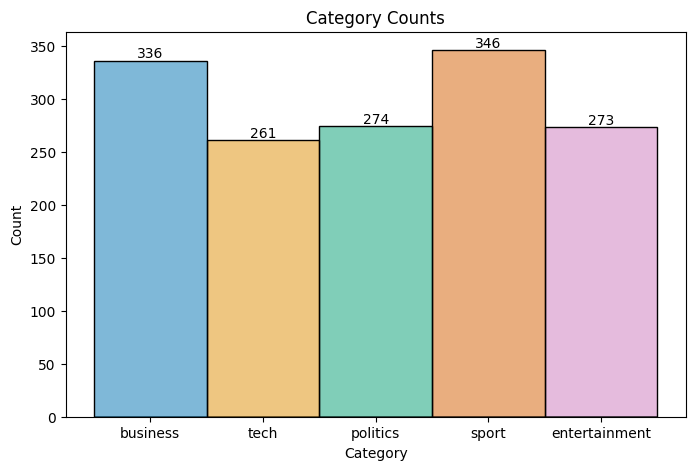

In [174]:
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_data,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts')

add_histogram_values(ax)

In [175]:
train_data['text multiplicity'] = train_data.groupby('Text')['Text'].transform('count').astype(str) 


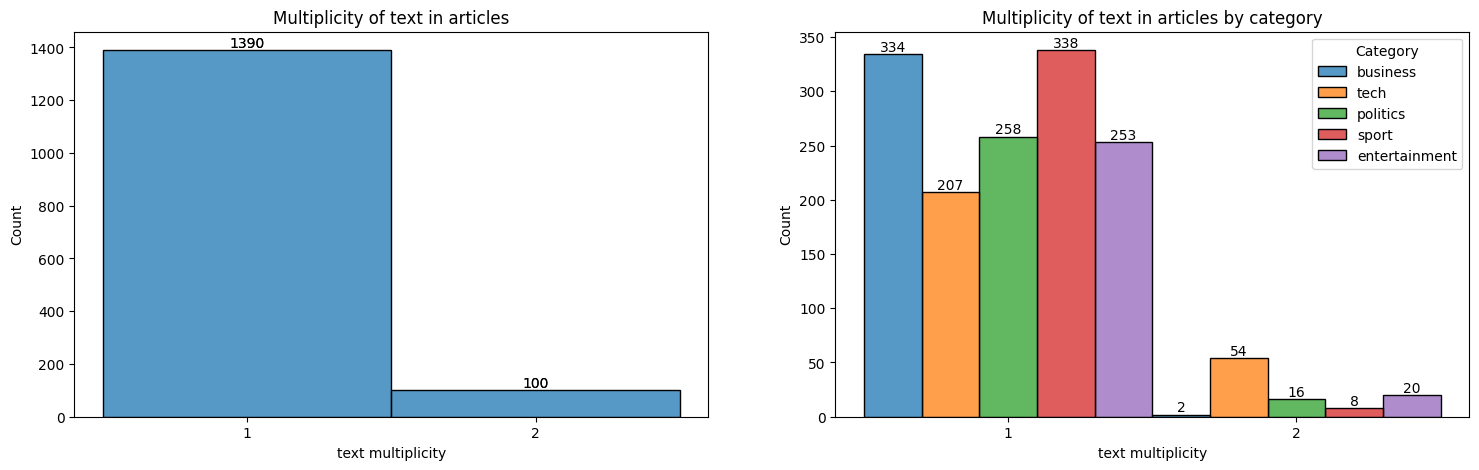

In [176]:
fig, ax = plt.subplots(ncols=2,figsize=(18, 5))

# Histogram showing repeated text multiplicity in training dataframe
ax2 = sns.histplot(
    ax = ax[0],
    data = train_data,
    x='text multiplicity',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles')
add_histogram_values(ax[0])
# Same histogram, by Category
ax2 = sns.histplot(
    ax = ax[1],
    data = train_data,
    x='text multiplicity',
    hue = 'Category',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles by category')
add_histogram_values(ax[0])
add_histogram_values(ax[1])

In [177]:
# Check how many categories are in each repeated text group
print(train_data[train_data['text multiplicity']!='1'].groupby('Text', as_index=False)['Category'].nunique().head())
print("--"*30,"\n")
print('The maximum number of different categories assigned to repeated texts is: {}'.format(\
train_data[train_data['text multiplicity']!='1'].groupby('Text')['Category'].nunique().max()))

                                                Text  Category
0  ask jeeves joins web log market ask jeeves has...         1
1  aviator  creator  in oscars snub the man who s...         1
2  blind student  hears in colour  a blind studen...         1
3  bortolami predicts dour contest italy skipper ...         1
4  britons fed up with net service a survey condu...         1
------------------------------------------------------------ 

The maximum number of different categories assigned to repeated texts is: 1


## Cleaning data

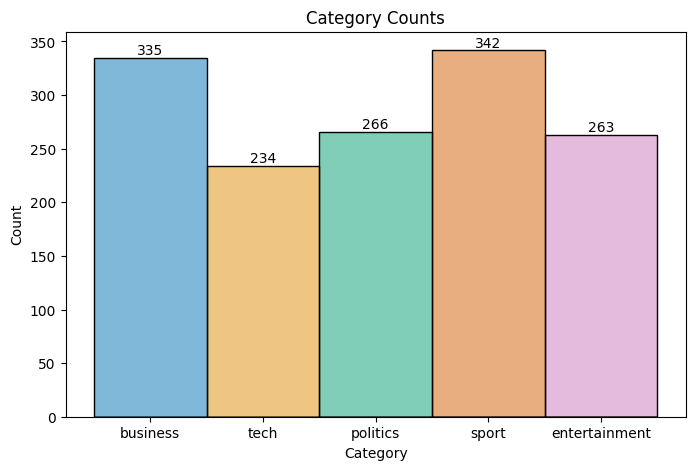

In [178]:
train_data = train_data.drop_duplicates(subset=['Text'])

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_data,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts')

add_histogram_values(ax)

In [179]:
import re

def show_special_words(text:str):
    print("Money format")
    print(re.findall(r'[\$\£\€\¥]\d+(?:\.\d+)?[a-zA-Z]*',text))
    print("Number format")
    print(set(re.findall(r'\s*(\d+(?:[\.\s]\d+)?)(?![%])', text)))
    print("Percentage format")
    print(set(re.findall(r'\b(\d+(?:\.\d+)?%)',text)))
    print("Non alpha-numeric symbols")
    print(set(re.findall(r'[^a-zA-Z0-9 ]', text)))

print('*'*40)
print('Sample text:')
print(train_data['Text'][0])
print('*'*40)
print('Special "words":')
print('-'*40)
show_special_words(train_data['Text'][0])

****************************************
Sample text:
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to 

In [180]:
for i in range(3): show_special_words(train_data["Text"][i])

Money format
['$11bn', '£5.7bn', '$6.75bn']
Number format
{'5.7', '11', '2004', '6.75', '85', '2002', '2001'}
Percentage format
set()
Non alpha-numeric symbols
{'£', '$', '.', ')', '-', '('}
Money format
[]
Number format
{'0', '2003', '2004', '97.5', '1', '95.5'}
Percentage format
{'2%', '10%', '1.6%', '0.2%'}
Non alpha-numeric symbols
{'-', '%', '.'}
Money format
[]
Number format
{'14', '22 953', '13', '23 000', '2004', '2.5', '5', '4', '3', '2005', '22', '2001', '15'}
Percentage format
{'48%', '41%', '36%', '44%', '47%', '34%'}
Non alpha-numeric symbols
{'.', ')', '%', '-', '(', ':'}


In [181]:
def normalize_text(text:str, keep_dots = False):
    text = text.lower()
    text = re.sub(r'[\$\£\€\¥]\d+(?:\.\d+)?[a-zA-Z]*',"money",text)
    text = re.sub(r'\b(\d+(?:\.\d+)?%)'," percentage", text)
    text = re.sub(r'\s*(\d+(?:[\.\s]\d+)?)(?![%])'," number", text)
    clean_dot_regex = r'[^a-zA-Z0-9\. ]' if keep_dots else r'[^a-zA-Z0-9 ]'
    text = re.sub(clean_dot_regex,' ', text)
    return text

def clean_text(df:pd.DataFrame, keep_dots= False):
    if keep_dots:
        clean_method = lambda x: normalize_text(x, True)
    else:
        clean_method = normalize_text
    
    try:
        return df['Text'].apply(clean_method)
    except KeyError:
        return df.apply(clean_method)

train_data["Text"] = train_data["Text"].apply(normalize_text)
for i in range(3): show_special_words(train_data["Text"][i])

Money format
[]
Number format
set()
Percentage format
set()
Non alpha-numeric symbols
set()
Money format
[]
Number format
set()
Percentage format
set()
Non alpha-numeric symbols
set()
Money format
[]
Number format
set()
Percentage format
set()
Non alpha-numeric symbols
set()


In [182]:
train_data['word count'] = train_data['Text'].apply(lambda row: len(row.split()))
train_data['char count'] = train_data['Text'].apply(lambda row: len(row))

train_data

,ArticleId,Text,Category,text multiplicity,word count,char count
0,1833,worldcom ex boss launches defence lawyers defe...,business,1,302,1877
1,154,german business confidence slides german busin...,business,1,326,2057
2,1101,bbc poll indicates economic gloom citizens in ...,business,1,514,3204
3,1976,lifestyle governs mobile choice faster bett...,tech,1,633,3663
4,917,enron bosses in money payout eighteen former e...,business,1,353,2204
...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1,230,1326
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1,561,3148
1487,1590,weak dollar hits reuters revenues at media gro...,business,1,236,1422
1488,1587,apple ipod family expands market apple has exp...,tech,1,560,3299


,ArticleId,word count,char count
count,1440.000000,1440.000000,1440.000000
mean,1118.146528,387.481944,2260.485417
std,642.822120,213.329712,1222.269372
min,2.000000,91.000000,506.000000
25%,560.750000,254.000000,1470.750000
50%,1111.000000,339.000000,1990.500000
75%,1681.250000,471.250000,2779.500000
max,2224.000000,3343.000000,18599.000000


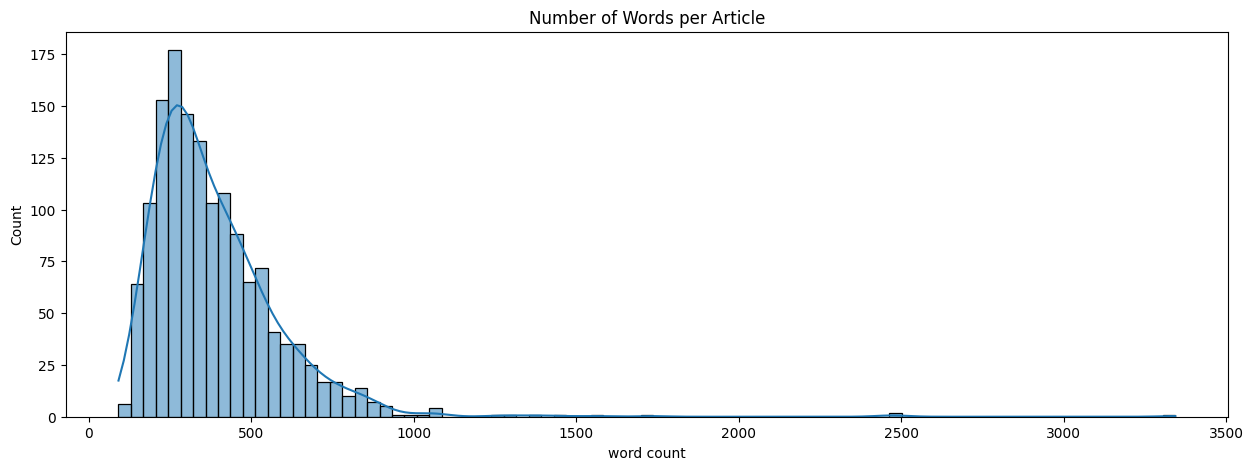

In [183]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train_data, 
    x = 'word count',
    kde=True,
    ).set(
        title = 'Number of Words per Article');
train_data.describe()

In [184]:
print('Word count statistics by category:')
word_count_by_category = train_data[['Category','word count']].groupby('Category')
word_count_by_category.describe()

Word count statistics by category:


word count                                                 
                   count        mean         std    min     25%    50%   
Category                                                                 
business           335.0  334.889552  133.208685  143.0  252.50  306.0  \
entertainment      263.0  336.737643  206.640438  143.0  230.00  270.0   
politics           266.0  451.680451  262.410997   91.0  319.50  443.5   
sport              342.0  341.119883  188.983731  118.0  217.25  299.0   
tech               234.0  514.589744  214.613602  186.0  347.25  465.0   

                               
                  75%     max  
Category                       
business       388.00   906.0  
entertainment  381.50  2468.0  
politics       528.75  3343.0  
sport          421.00  1730.0  
tech           644.50  1553.0

[Text(0.5, 1.0, 'Number of words per article by category')]

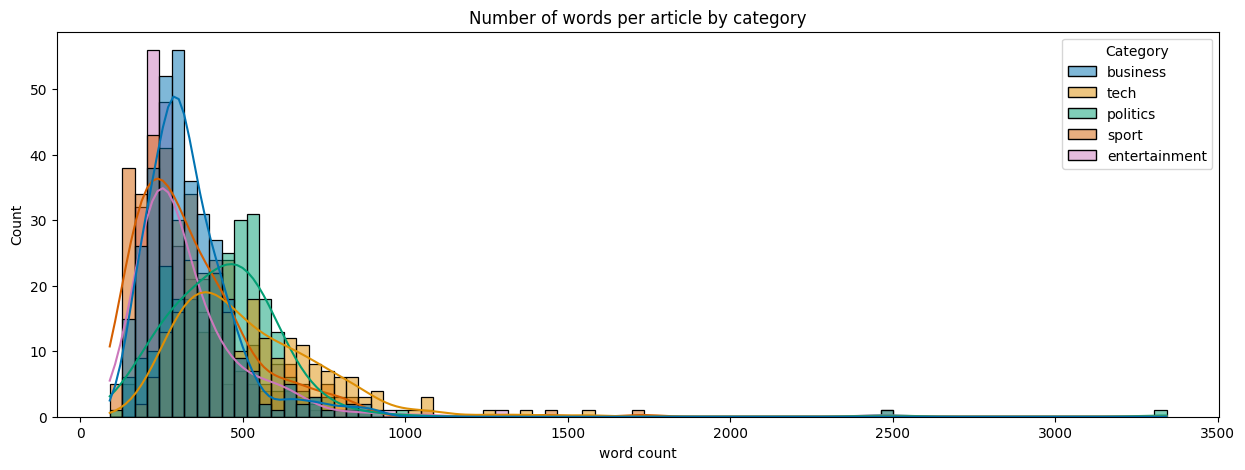

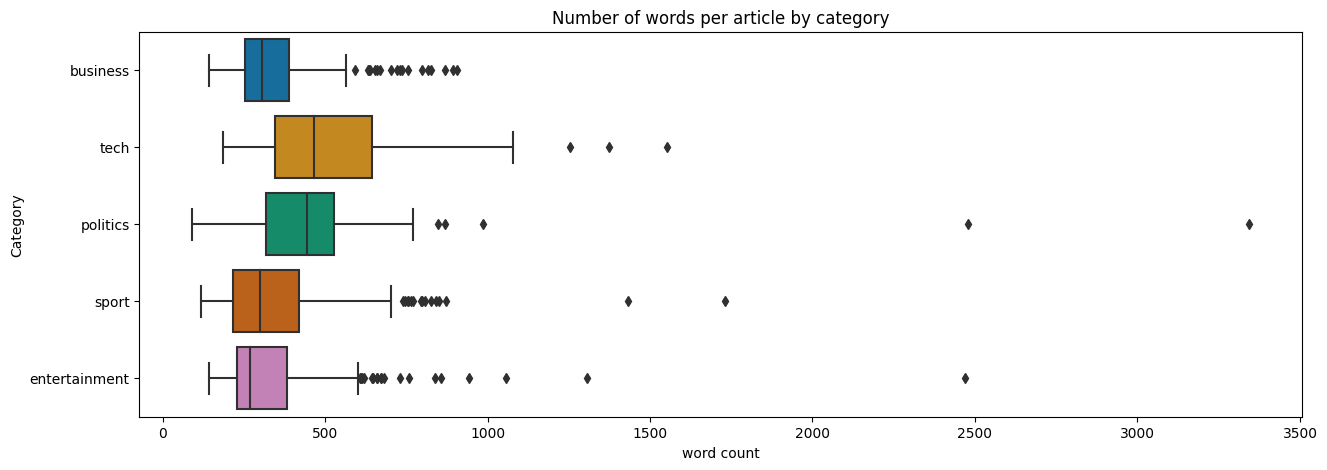

In [185]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train_data, 
    x = 'word count',
    palette = 'colorblind',
    kde=True,
    hue = 'Category'
    ).set(
        title = 'Number of words per article by category')

# words per category
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    data = train_data, 
    x = 'word count', 
    y = 'Category',
    palette = 'colorblind'
    ).set(
        title = 'Number of words per article by category')

## Processing data

Convert a collection of text documents to a matrix of token counts.

In [186]:
cv=CountVectorizer() 
word_count=cv.fit_transform(train_data['Text'])
print('There are {} documents in the training set.'.format(len(train_data)))
print('There are {} different words in the training set.'.format(word_count.shape[1]))
print('The sparse Matrix WC has size {} and its sparsity is {:.2f}%. '.format(word_count.shape,100*(1-word_count.count_nonzero()/np.prod(word_count.shape))))
print('\nCorresponding DataFrame to WC:')
counts_df = pd.DataFrame(word_count.A,columns=cv.get_feature_names_out())
counts_df

There are 1440 documents in the training set.
There are 23564 different words in the training set.
The sparse Matrix WC has size (1440, 23564) and its sparsity is 99.17%. 

Corresponding DataFrame to WC:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
print('The most popular words amog all documents are are:')
print('\nword  count')
print(counts_df.sum().sort_values().tail())

The most popular words amog all documents are are:

word  count
in     11424
and    11948
of     12582
to     16062
the    33933
dtype: int64


In [188]:
# Include category column into word count
counts_df['_category_']=train_data['Category']

print('Word count by category:')
word_count_by_category = counts_df.groupby('_category_').sum()
word_count_by_category

Word count by category:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
_category_,,,,,,,,,,,,,,,,,,,,,
business,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
entertainment,0,0,1,0,0,0,0,0,0,0,...,0,3,0,1,1,0,0,2,0,3
politics,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,3,0,0
sport,0,3,0,0,3,0,1,0,1,0,...,0,1,0,1,0,0,1,1,1,1
tech,0,0,0,3,0,4,0,0,1,1,...,1,0,2,0,0,2,0,1,0,0


In [189]:
is_unique = word_count_by_category.astype(bool).sum(axis=0)==1

total_word_count = word_count_by_category.sum(axis=0)

a = total_word_count[is_unique]
b = word_count_by_category.idxmax(axis=0)[is_unique]
c = cv.get_feature_names_out ()[is_unique]

unique_words =  pd.DataFrame(data=zip(a,b),index=c,columns=['unique word count','Category'])
print('Unique words per category:')
unique_words.groupby('Category').describe()

Unique words per category:


unique word count                                              
                          count      mean       std  min  25%  50%  75%   max
Category                                                                     
business                 2460.0  1.431707  1.093722  1.0  1.0  1.0  1.0  13.0
entertainment            2011.0  1.367976  1.105774  1.0  1.0  1.0  1.0  12.0
politics                 1811.0  1.464384  1.336784  1.0  1.0  1.0  1.0  28.0
sport                    2540.0  1.388189  1.136117  1.0  1.0  1.0  1.0  26.0
tech                     1929.0  1.429756  1.252121  1.0  1.0  1.0  1.0  18.0

In [190]:
C = unique_words.groupby('Category')
U = C.max()
U['top unique word'] = C.idxmax().iloc[:,0]
U

,unique word count,top unique word
Category,,
business,13,qantas
entertainment,12,ahold
politics,28,goldsmith
sport,26,uwb
tech,18,harriers


In [191]:
print('Top 10 Unique words and their count per category:')
for category,g, in C:
    print('\nCategory: ',category,'\n',g['unique word count'].nlargest(10).to_markdown())  

Top 10 Unique words and their count per category:

Category:  business 
 |            |   unique word count |
|:-----------|--------------------:|
| qantas     |                  13 |
| ufj        |                  11 |
| monsanto   |                  10 |
| arnesen    |                   9 |
| bofra      |                   9 |
| jol        |                   9 |
| pernod     |                   9 |
| ssl        |                   9 |
| bombardier |                   8 |
| greer      |                   8 |

Category:  entertainment 
 |            |   unique word count |
|:-----------|--------------------:|
| ahold      |                  12 |
| hailey     |                  12 |
| carnival   |                  11 |
| roundabout |                  11 |
| conti      |                  10 |
| elgindy    |                  10 |
| painkiller |                  10 |
| absa       |                   9 |
| binge      |                   9 |
| purushotma |                   9 |

Category: 

## Step 2: Building and training models

Transform a count matrix to a normalized tf or tf-idf representation [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

$tf$ means term-frequency while $tf-idf$ means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using $tf-idf$ instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

The formula that is used to compute the $tf-idf$ for a term $t$ of a document $d$ in a document set is $tf-idf(t, d) = tf(t, d) * idf(t)$, and the $idf$ is computed as $idf(t) = log [\frac{n}{df(t)} ] + 1$ (if smooth_idf=False), where $n$ is the total number of documents in the document set and $df(t)$ is the document frequency of $t$; the document frequency is the number of documents in the document set that contain the term $t$. The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the idf formula above differs from the standard textbook notation that defines the $idf$ as $idf(t) = log [\frac{n}{df(t) + 1}]$).

In [192]:
tfidf_transformer=TfidfTransformer() 
WC2 = tfidf_transformer.fit_transform(word_count)

tfidf_df = pd.DataFrame(WC2.A,columns = cv.get_feature_names_out ())
print('WC2 matrix representation:')
tfidf_df

WC2 matrix representation:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
print('Raking of word scores in WC2:','\n\t\tcolumn sum:')
print(tfidf_df.sum().sort_values())

Raking of word scores in WC2: 
		column sum:
tangible         0.012346
asians           0.012346
overtime         0.012346
hardworking      0.012346
whining          0.012346
                  ...    
and            105.856535
in             106.049515
of             111.623695
to             142.632729
the            303.945870
Length: 23564, dtype: float64


In [194]:
print("Weights given to words by idf:")
pd.DataFrame(tfidf_transformer.idf_, cv.get_feature_names_out(), columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by idf:


,idf_weights
the,1.000000
to,1.003476
of,1.006964
in,1.008362
and,1.010464
...,...
ffion,7.579945
feyenoord,7.579945
fewest,7.579945
fickle,7.579945


In [195]:
print("Subset of the words that are in all categories (universal words):")
is_in_all_cats = word_count_by_category.astype(bool).sum(axis=0)==5
universal_words = pd.DataFrame(word_count.getnnz(axis=0)[is_in_all_cats], # nnz = number of nonzero entries per column (count of articles with word)
                               index=word_count_by_category.columns[is_in_all_cats]._data,
                               columns=['#of Articles with this word'])
universal_words.head()

Subset of the words that are in all categories (universal words):


,#of Articles with this word
ability,60
able,169
about,623
above,40
abroad,27


,#of Articles with this word
count,3952.000000
mean,58.717105
std,125.778436
min,5.000000
25%,14.000000
50%,24.000000
75%,53.000000
max,1440.000000


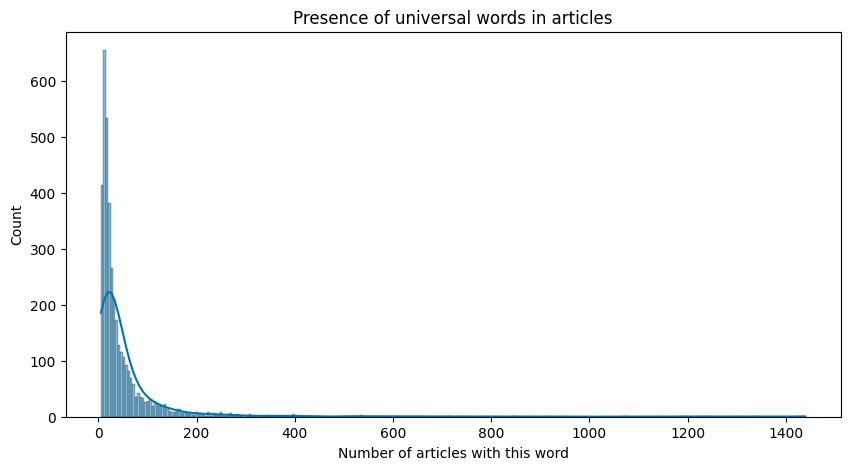

In [196]:
fig, axs = plt.subplots(ncols=1,figsize=(10, 5))
sns.histplot(
    ax=axs,
    data = universal_words, 
    legend = False,
    palette = 'colorblind',
    kde = True,
    ).set(
        title = 'Presence of universal words in articles',
        xlabel='Number of articles with this word');
universal_words.describe()

In [197]:
print('These are the 50 most common universal words:')
print(universal_words.iloc[:,0].nlargest(50))
print("\nRemark: The word money is found in {} articles".format(universal_words.loc['money'][0]))

These are the 50 most common universal words:
the       1440
to        1435
of        1430
in        1428
and       1425
number    1344
for       1335
on        1297
it        1246
is        1239
said      1226
with      1202
that      1194
has       1185
was       1157
at        1135
be        1113
by        1113
have      1076
as        1074
but       1069
from      1024
will       949
an         928
are        922
he         910
not        885
this       850
which      850
been       844
had        803
up         803
also       792
year       776
they       752
would      742
their      733
who        719
were       714
more       701
one        686
after      663
out        663
his        652
its        648
we         646
new        644
about      623
over       613
there      609
Name: #of Articles with this word, dtype: int64

Remark: The word money is found in 564 articles


In [198]:
# Compute which words are unique, intermediate or universal
universal_words['type']='universal'
is_interm_freq_word = ~is_in_all_cats & ~is_unique
intermediate_words =  pd.DataFrame(word_count.getnnz(axis=0)[is_interm_freq_word], # nnz = number of nonzero entries per column (count of articles with word)
                               index=word_count_by_category.columns[is_interm_freq_word]._data,
                               columns=['#of Articles with this word'])
intermediate_words['type']='intermediate'

unique_words =  pd.DataFrame(word_count.getnnz(axis=0)[is_unique], # nnz = number of nonzero entries per column (count of articles with word)
                               index=word_count_by_category.columns[is_unique]._data,
                               columns=['#of Articles with this word'])
unique_words['type']='unique' #defined in a previous cell.

word_types = pd.concat([unique_words,intermediate_words,universal_words],axis=0)

word_types

,#of Articles with this word,type
aa,1,unique
aaa,3,unique
aac,1,unique
aadc,1,unique
aaliyah,1,unique
...,...,...
youth,8,universal
yukos,18,universal
zealand,31,universal
zero,12,universal


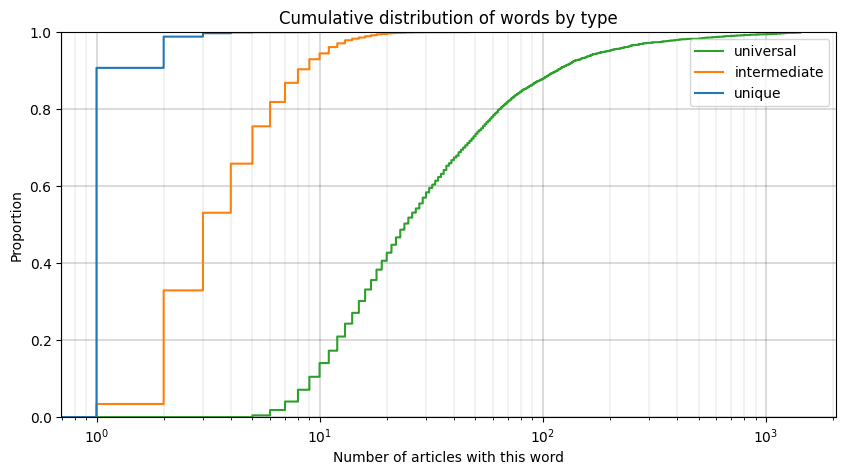


Presence of words in articles by word type:



#of Articles with this word                                     
                                   count       mean         std  min   25%   
type                                                                         
intermediate                      8861.0   4.396344    3.260303  1.0   2.0  \
unique                           10751.0   1.108734    0.377000  1.0   1.0   
universal                         3952.0  58.717105  125.778436  5.0  14.0   

                                  
               50%   75%     max  
type                              
intermediate   3.0   5.0    47.0  
unique         1.0   1.0     9.0  
universal     24.0  53.0  1440.0

In [199]:
fig, axs = plt.subplots(ncols=1,figsize=(10, 5))
k=0
hue_order=['unique','intermediate','universal']
s=sns.ecdfplot(data = word_types,
             x= '#of Articles with this word',
             hue = "type",
             hue_order=hue_order,
             legend = False,                
             log_scale=(True,False),
#              label = hue_order
            ).set(
        title = 'Cumulative distribution of words by type',
        xlabel='Number of articles with this word');

axs.grid(visible=True, which='major', color='black', linewidth=0.2)
axs.grid(visible=True, which='minor', color='black', linewidth=0.075)
axs.legend(labels=hue_order[::-1])
plt.show()


word_types = word_types.groupby('type')
print('\nPresence of words in articles by word type:\n')
word_types.describe()

In [200]:
def get_word_type_and_count(word:str, word_types:pd.DataFrame):
    """ Returns a pandas series with word type and #of Articles with this word"""
    for word_type, group_df in word_types:
        try:
            return group_df.loc[word,:]
        except KeyError:
            pass
def print_word_type_and_count(word:str, word_types:pd.DataFrame):
    word_info = get_word_type_and_count(word, word_types)
    print("The word '{}' is of {} type, found in {} articles.".format(
        word, word_info['type'], word_info['#of Articles with this word']))     

Boxplots of word count per category for chosen words:
The word 'money' is of universal type, found in 564 articles.
The word 'number' is of universal type, found in 1344 articles.


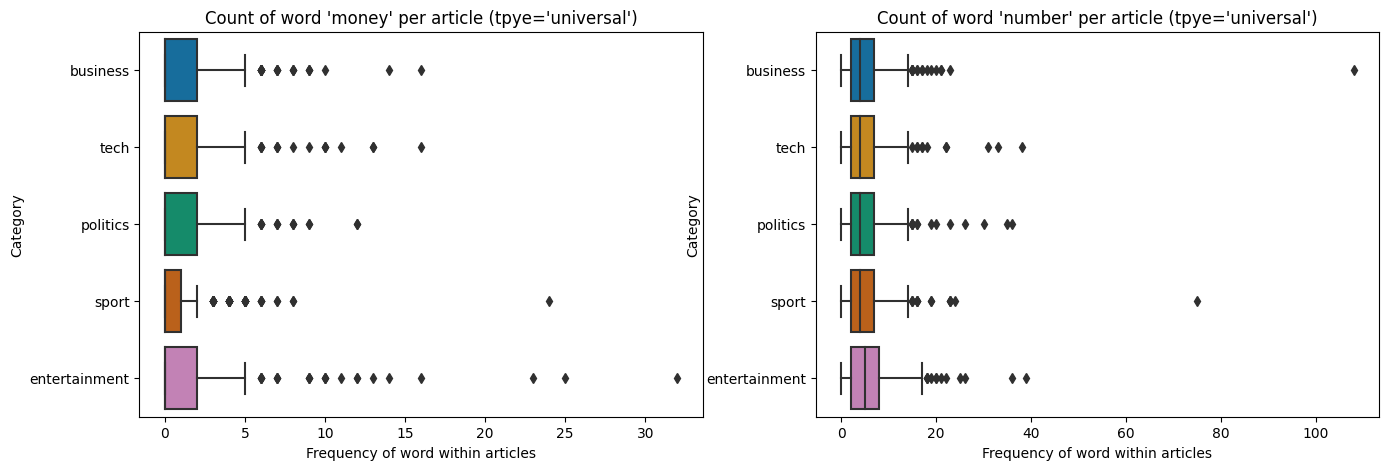

In [201]:
print('Boxplots of word count per category for chosen words:')
fig, axs = plt.subplots(ncols=2,figsize=(16, 5))
words = ('money','number')
for i,word in enumerate(words):
    word_type = get_word_type_and_count(word,word_types)['type']
    print_word_type_and_count(word,word_types)
    
    sns.boxplot(        
        ax = axs[i],
        data = counts_df, 
        x = word, 
        y = '_category_',
        palette = 'colorblind',    
        ).set(
            title = "Count of word '{}' per article (tpye='{}')".format(word,word_type),
            xlabel = 'Frequency of word within articles',
            ylabel = 'Category')

# Building and training models

In [202]:
train_df, crossval_df = train_test_split(train_data,stratify=train_data[['Category']],test_size=0.2,random_state = 310)
print('Training set:')
train_df

Training set:


,ArticleId,Text,Category,text multiplicity,word count,char count
633,1805,dublin hi tech labs to shut down dublin s hi t...,tech,1,571,3407
457,1717,regiments group in poll move a regiments cam...,politics,1,354,2174
1233,555,bnp leader nick griffin arrested the leader of...,politics,1,206,1274
1372,557,barbarians number number new zealand new zeal...,sport,1,443,2484
489,563,cable offers video on demand cable firms ntl a...,tech,1,584,3369
...,...,...,...,...,...,...
625,814,us budget deficit to reach money the us budget...,business,1,316,1899
1093,70,indonesia declines debt freeze indonesia no ...,business,1,352,2128
1068,825,prime minister s questions so who if anyone ...,politics,1,423,2458
470,1686,de niro completes box office coup robert de ni...,entertainment,1,244,1374


In [203]:
print('Cross validation set:')
crossval_df

Cross validation set:


,ArticleId,Text,Category,text multiplicity,word count,char count
936,1714,bmw drives record sales in asia bmw has foreca...,business,1,269,1553
196,1696,new yob targets to be unveiled fifty new are...,politics,1,416,2463
793,660,beckham rules out management move real madrid ...,sport,1,255,1426
851,2185,japanese mogul arrested for fraud one of japan...,business,1,430,2482
668,328,nadal marches on in mexico rafael nadal contin...,sport,1,218,1327
...,...,...,...,...,...,...
201,601,snow patrol feted at irish awards snow patrol ...,entertainment,1,249,1458
1485,857,double eviction from big brother model caprice...,entertainment,1,230,1326
1477,883,web logs aid disaster recovery some of the mos...,tech,1,699,3961
92,212,straw attacked on china arms moves to lift the...,politics,1,499,2813


In [204]:
class MyData(object):
    """
    Represent text data as a sparse matrix with TfidfVectorizer
    Note: This class does not follow sklearn syntax. 
    """
    def __init__(self,df,TfidfVec:TfidfVectorizer=None,clean_text=True,**TtdifVec_kwargs):
        """
        Inputs:
        -df: a DataFrame including column "Text"
        -TfidfVec: previously fitted TfidfVectorizer object (pass None for a new fit)        
        -clean_text: if True, 'Text' column will be cleaned.
        -TtdifVec_kwargs: parameters to pass when the TfidfVectorizer is created
        Fields:
        -MyData.words: list of words used by TfidfVec
        -MyData.tv: fitted TfidfVectorizer object
        -MyData.WC2: Sparse matrix representation of the text
        """
        self.df = df.copy()
        if clean_text:
            self.clean_text()
        self.get_WC2(TfidfVec,**TtdifVec_kwargs)
    def clean_text(self):
        self.df['Text'] = clean_text(self.df)
    def get_WC2(self,TfidfVec:TfidfVectorizer=None,**TtdifVec_kwargs):
        """
        Fit TfidfVectorizer to text and return a sparse matrix from tf-idf
        """
        if TfidfVec is None:
            # This is fit only done with the training data set.
            if len(TtdifVec_kwargs)==0:
                # Fit with default parameters
                self.tv = TfidfVectorizer(min_df=0.004,max_df=0.417)  
            else:
                # Fit with user defined parameters
                self.tv = TfidfVectorizer(**TtdifVec_kwargs)
                
            self.WC2 = self.tv.fit_transform(self.df['Text'])
        else:
            # The user passed the training TfidfVectorizer object
            self.tv = TfidfVec  
            self.WC2 = self.tv.transform(self.df['Text'])
        self.words = self.tv.get_feature_names_out()                   
 
    def get_WC2_as_df(self):
        """Converts the sparse matrix WC2 into a full DataFrame"""
        return pd.DataFrame(self.WC2.A,columns=self.words)
    def __repr__(self):
        return "MyData( nwords={} )".format(self.WC2.shape)
    def __str__(self):
        return  self.__repr__()

    @staticmethod
    def plot_confusion_matrix(y_true,y_pred,title='Confusion Matrix'):        
        labels = list(set(y_pred).union(set(y_true)))        
        cm = confusion_matrix(y_true,y_pred,labels=labels)
        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt='g',ax=ax);
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title(title); 
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);                             
            
train_data = MyData(train_df)
crossval_data = MyData(crossval_df,train_data.tv)
test_data = MyData(test_data,train_data.tv)
print('WC2 in training data set has size:',train_data.WC2.shape)
print('WC2 in crossval_data data set has size:',crossval_data.WC2.shape)
print('WC2 in test_data data set has size:',test_data.WC2.shape)

WC2 in training data set has size: (1152, 6047)
WC2 in crossval_data data set has size: (288, 6047)
WC2 in test_data data set has size: (735, 6047)


In [205]:
from itertools import permutations


class MyNMF(object):
    """
    NMF model with helper methodsMyData obj
    Note: This class does not follow sklearn syntax. 
          I did refactor it but I was unable to make it work with categorical predictions,
          so all changes were undone.
    """
    def __init__(self, n_topics,**fit_params):
        """
        Inputs:
        -Xtrain_data: a MyData object
        -n_topics: number o topics to represent text
        -**fit_params: optional kwargs to pass when sklearn's NMF object is created
        """        
        self.n_topics = n_topics
        self.fit_params = fit_params        
        self.mapping_dict = None
    def fit(self,Xtrain_data:MyData,ytrain=None):
        
        # Default values
        self.fit_params['n_components'] = self.n_topics
        self.fit_params['beta_loss'] = self.fit_params.get('beta_loss',"frobenius")
        self.fit_params['init'] = self.fit_params.get('init',"nndsvda")
        
        # Fit NMF model and store matrix W such that WC2 = W*H
        self.model_ = NMF(**self.fit_params).fit(Xtrain_data.WC2)
        self.words_ = Xtrain_data.words
        
        
        if ytrain is None:
            # Trivial categories
            self.mapping_dict_ = {i:i for i in range(self.n_topics)}
            return self
        
        W = self.transform(Xtrain_data)
        pred_ids = self.predict_topic_ids(W)
        self.train_score_, _, _ = self.match_topic_ids_to_categories(pred_ids,ytrain)        
        return self
    
    def predict(self,Xdata):
        W = self.transform(Xdata)
        pred_ids = self.predict_topic_ids(W)
        y_pred = self.map_topic_id_to_cats(pred_ids)
        return y_pred
    def transform(self,Xdata):
        W = self.model_.transform(Xdata.WC2)
        return W     
    def predict_topic_ids(self,W):    
        """ Returns indexes of largest rows in W for NMF model. There are the predicted topic ids per article"""
        return [np.argmax(row) for row in W]
    
    def match_topic_ids_to_categories(self,pred_ids,y_true,
                                      metric=metrics.accuracy_score):   
        """        
        Try permutations to map pred_ids with the categories in y_true by maximizing a given metric
        Inputs:
        - pred_ids: vector of predicted topic ids (from matrix W)
        - y_true: true categories. (Category column in dataframe)
        - metric: desired metric function with args metric(y_true,y_pred) to be maximized. Default: accuracy_score
        Returns:
        - best_metric: achieve score
        - y_pred_best: list of predicted categories
        - best_perm: dictionary containing the mapping of unique values in pred_ids to each category
        """           
        # It could be the case that there is a different number of unique elements in pred_ids and y_true.        
        # We force the mapping to fit into the categories in y_true        
        cats = set(y_true) 
        num_cats = len(cats)                      
        
        # initial guess
        id_to_cat = {i:c for i,c in enumerate(cats)} # we try all permutations of the keys of this dictionary  
        
        y_pred_best = [id_to_cat[c] for c in pred_ids]        
        best_metric = metric(y_true,y_pred_best)
        best_perm = id_to_cat
        # Find a permutation to maximize given metric
        for perm_ids in permutations(id_to_cat):
            id_to_cat = {i:c for i,c in zip(perm_ids,cats)}
            y_pred = [id_to_cat[c] for c in pred_ids] 
            curr_metric = metric(y_true,y_pred)
            if curr_metric>best_metric:
                best_metric = curr_metric
                y_pred_best = y_pred
                best_perm = id_to_cat   
        self.mapping_dict_ = best_perm
        return best_metric,y_pred_best,best_perm
    
    def map_topic_id_to_cats(self,pred_ids,mapping_dict=None):
        """
        Convert column indexes in W to categories based on a mapping dictionary
        """
        if mapping_dict is None: mapping_dict = self.mapping_dict_
        return list(map(lambda ix: mapping_dict[ix],pred_ids))
    
    def get_topic_words(self,n_words):
        """"
        Get dictionary with topic id and n words per topic from matrix H in NMF
        Inputs:
        - n_words: number of words to represent each topic
        """ 
        # Matrix H: each column is a word, each row is a topic.
        # Words with highest scores are representative of a topic
        H = self.model_.components_ 
        
        topic_names = [self.mapping_dict_[k] for k in range(self.n_topics)]
        
        topics_dict = {topic_names[k]: list(self.words_[MyNMF.get_ind_largest(row,n_words)]) \
                       for k,row in enumerate(H)}        
        return topics_dict
    
    def print_top_words(self,n_words:int =4):        
        """Print a list of top words and the corresponding topic"""
        print('Top {} words per topic:'.format(n_words))
        topics_dict = self.get_topic_words(n_words)
        [print('words: {} => topic: {}'.format(v,k)) for k,v in topics_dict.items()];
        
    def __repr__(self):
            return "NMF model  with {} words and {} topics".format(len(self.words_),self.n_topics)
    def __str__(self):
            return self.model_.__str__()         
    @staticmethod
    def get_ind_largest(x,k):
        """
        Return indexes of k largest components in a 1 D numpy array.
        (Fast method)
        """        
        ind_largest= x.argpartition(-k)[-k:] # this is O(n), but unsorted.
        return ind_largest[np.argsort(-x[ind_largest])]    
    @staticmethod
    def plot_topic_words(H, words, n_words, title,word_types=None):
        """Producs a bar plot for each predicted NMF topic showing the highest n scores and their words per topic"""
        num_topics = H.shape[0]
        ncols = 5
        nrows = int(np.ceil(num_topics/ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(30, 8), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(H):
            ind_largest = MyNMF.get_ind_largest(topic,n_words)
            top_words = words[ind_largest]
            weights = topic[ind_largest]
            ax = axes[topic_idx]
            ax.barh(top_words, weights, height=0.5)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 25})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=16)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)                
            fig.suptitle(title, fontsize=30)
            
            # What is the type of the most representative word?
            if word_types is not None: print_word_type_and_count(top_words[0],word_types)

In [206]:
n_top_words = 4
n_topics = 5
print('*'*55)
print('  Performing NMF X = W*H with {} topics on training set'.format(n_topics))
print('*'*55)
nmf_model = NMF(n_topics,
                beta_loss='frobenius',
               init='nndsvda')
W_train =nmf_model.fit_transform(train_data.WC2)

H_train = nmf_model.components_
print('The chosen latent dimension p is:',n_topics)
print('The size of W for training set is:',W_train.shape)
print('The size of H for training set is:',H_train.shape)
print('=>W train:\n',W_train)
print('=>H train:\n',H_train)

*******************************************************
  Performing NMF X = W*H with 5 topics on training set
*******************************************************
The chosen latent dimension p is: 5
The size of W for training set is: (1152, 5)
The size of H for training set is: (5, 6047)
=>W train:
 [[0.0171293  0.02722972 0.02034002 0.         0.13781556]
 [0.00101278 0.02297812 0.16342234 0.         0.        ]
 [0.         0.00649153 0.05361609 0.02165633 0.        ]
 ...
 [0.         0.01171414 0.22194208 0.         0.        ]
 [0.02823905 0.00402463 0.         0.14734516 0.        ]
 [0.         0.00297444 0.01254031 0.         0.1944177 ]]
=>H train:
 [[0.00272415 0.00035801 0.         ... 0.00541687 0.01121636 0.00073237]
 [0.0010895  0.         0.00266925 ... 0.00930664 0.00730751 0.00966862]
 [0.00646245 0.         0.00578628 ... 0.00318505 0.00059838 0.        ]
 [0.00515927 0.02286828 0.         ... 0.         0.00140978 0.        ]
 [0.         0.00194957 0.00104701 ..

In [207]:
print("H train contains coefficients to p={} rows (topics), each defined by a combination of {} words.".format(*H_train.shape))
print("We will represent each topic (row) with the {} words that have the largest coefficient in H".format(n_top_words))

topics = {i:list(train_data.words[MyNMF.get_ind_largest(row,n_top_words)])  for i,row in enumerate(H_train)}
print(topics)

for i,row in enumerate(H_train):
    ind_largest = MyNMF.get_ind_largest(row,n_top_words)
    print('\nTopic in Row {} is represented by the words: \n{} with coefficients:\n{}'.format(
        i,train_data.words[ind_largest],np.round(row[ind_largest],2)))
print('\nCompare these words to the official categories:\n',set(train_data.df['Category']))

H train contains coefficients to p=5 rows (topics), each defined by a combination of 6047 words.
We will represent each topic (row) with the 4 words that have the largest coefficient in H
{0: ['percentage', 'money', 'growth', 'us'], 1: ['england', 'game', 'win', 'wales'], 2: ['mr', 'labour', 'blair', 'election'], 3: ['film', 'best', 'her', 'awards'], 4: ['mobile', 'people', 'phone', 'technology']}

Topic in Row 0 is represented by the words: 
['percentage' 'money' 'growth' 'us'] with coefficients:
[0.92 0.87 0.46 0.44]

Topic in Row 1 is represented by the words: 
['england' 'game' 'win' 'wales'] with coefficients:
[0.37 0.31 0.24 0.23]

Topic in Row 2 is represented by the words: 
['mr' 'labour' 'blair' 'election'] with coefficients:
[0.63 0.51 0.46 0.44]

Topic in Row 3 is represented by the words: 
['film' 'best' 'her' 'awards'] with coefficients:
[0.89 0.45 0.33 0.33]

Topic in Row 4 is represented by the words: 
['mobile' 'people' 'phone' 'technology'] with coefficients:
[0.38 0.3

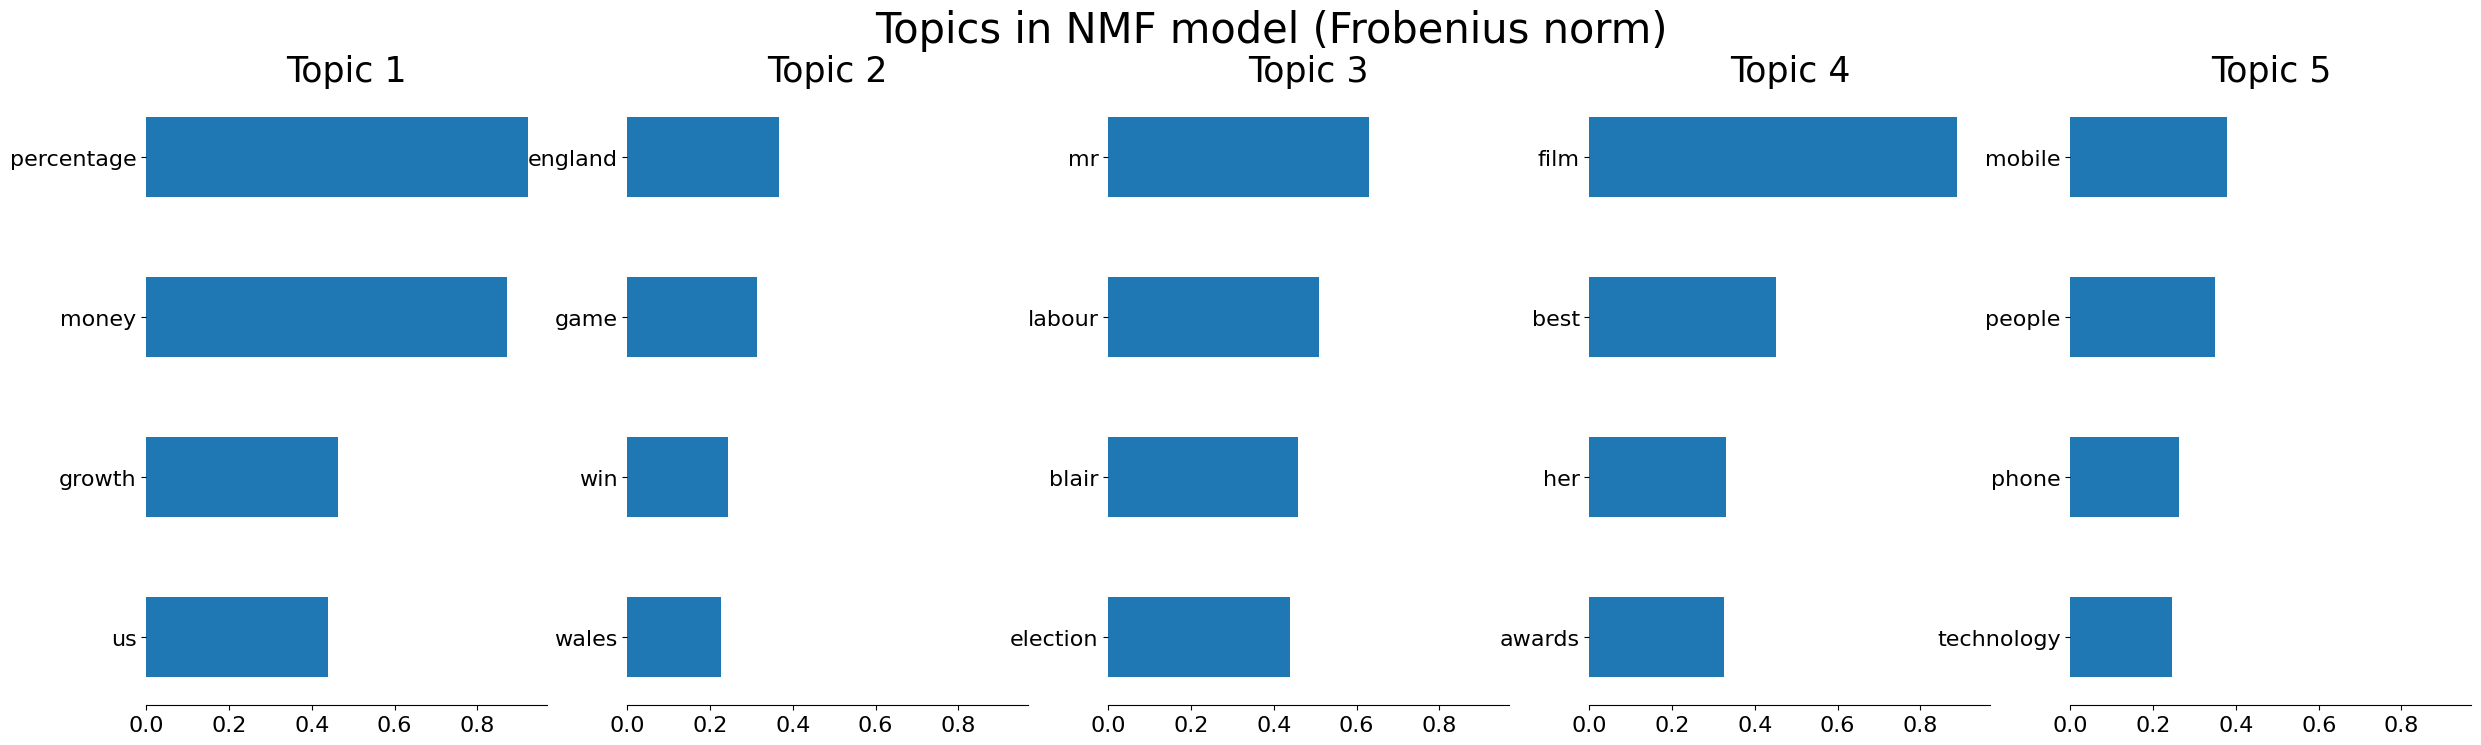

In [208]:
MyNMF.plot_topic_words(H_train,train_data.words,n_top_words,
               "Topics in NMF model (Frobenius norm)")

In [209]:
print('Training set with category and predicted topics:')
t_df= train_df.copy()
t_df['predicted_topics']=[topics[np.argmax(article)] for article in W_train]
t_df['predicted_topic_id']=[np.argmax(article) for article in W_train]
t_df['cat_id']=t_df['Category'].factorize()[0]
t_df

Training set with category and predicted topics:


,ArticleId,Text,Category,text multiplicity,word count,char count,predicted_topics,predicted_topic_id,cat_id
633,1805,dublin hi tech labs to shut down dublin s hi t...,tech,1,571,3407,"[mobile, people, phone, technology]",4,0
457,1717,regiments group in poll move a regiments cam...,politics,1,354,2174,"[mr, labour, blair, election]",2,1
1233,555,bnp leader nick griffin arrested the leader of...,politics,1,206,1274,"[mr, labour, blair, election]",2,1
1372,557,barbarians number number new zealand new zeal...,sport,1,443,2484,"[england, game, win, wales]",1,2
489,563,cable offers video on demand cable firms ntl a...,tech,1,584,3369,"[mobile, people, phone, technology]",4,0
...,...,...,...,...,...,...,...,...,...
625,814,us budget deficit to reach money the us budget...,business,1,316,1899,"[percentage, money, growth, us]",0,4
1093,70,indonesia declines debt freeze indonesia no ...,business,1,352,2128,"[percentage, money, growth, us]",0,4
1068,825,prime minister s questions so who if anyone ...,politics,1,423,2458,"[mr, labour, blair, election]",2,1
470,1686,de niro completes box office coup robert de ni...,entertainment,1,244,1374,"[film, best, her, awards]",3,3


In [210]:
# Repeat the above calculations using class methods from MyNMF:
y_true_train = train_data.df['Category']
nmf_model = MyNMF(n_topics=5).fit(train_data,y_true_train)
y_pred_train = nmf_model.predict(train_data)
acc = metrics.accuracy_score(y_true_train,y_pred_train)
nmf_model.print_top_words(10)

print('\nNMF predictions for the training set. (Accuracy = {:.3f}%)'.format(acc*100))
t_df= train_df.copy()
t_df['predicted Category (y_pred)']=y_pred_train
t_df

Top 10 words per topic:
words: ['percentage', 'money', 'growth', 'us', 'economy', 'sales', 'market', 'oil', 'economic', 'bank'] => topic: business
words: ['england', 'game', 'win', 'wales', 'ireland', 'against', 'first', 'you', 'she', 'side'] => topic: sport
words: ['mr', 'labour', 'blair', 'election', 'party', 'brown', 'government', 'minister', 'prime', 'howard'] => topic: politics
words: ['film', 'best', 'her', 'awards', 'award', 'she', 'actor', 'oscar', 'actress', 'money'] => topic: entertainment
words: ['mobile', 'people', 'phone', 'technology', 'can', 'users', 'or', 'net', 'software', 'you'] => topic: tech

NMF predictions for the training set. (Accuracy = 91.840%)


,ArticleId,Text,Category,text multiplicity,word count,char count,predicted Category (y_pred)
633,1805,dublin hi tech labs to shut down dublin s hi t...,tech,1,571,3407,tech
457,1717,regiments group in poll move a regiments cam...,politics,1,354,2174,politics
1233,555,bnp leader nick griffin arrested the leader of...,politics,1,206,1274,politics
1372,557,barbarians number number new zealand new zeal...,sport,1,443,2484,sport
489,563,cable offers video on demand cable firms ntl a...,tech,1,584,3369,tech
...,...,...,...,...,...,...,...
625,814,us budget deficit to reach money the us budget...,business,1,316,1899,business
1093,70,indonesia declines debt freeze indonesia no ...,business,1,352,2128,business
1068,825,prime minister s questions so who if anyone ...,politics,1,423,2458,politics
470,1686,de niro completes box office coup robert de ni...,entertainment,1,244,1374,entertainment



Accuracy for training set based on NMF: 91.840%


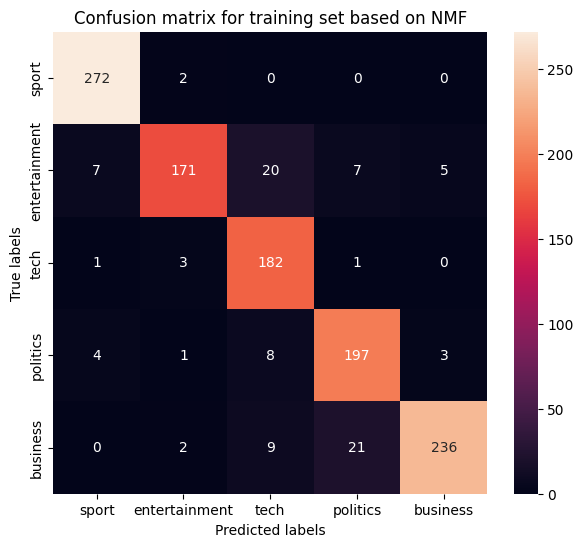

In [211]:
#Compute accuracy and confusion matrix.
print('\nAccuracy for training set based on NMF: {:.3f}%'.format(acc*100))
MyData.plot_confusion_matrix(y_true_train,y_pred_train,'Confusion matrix for training set based on NMF')


Accuracy for cross val set based on NMF: 88.542%


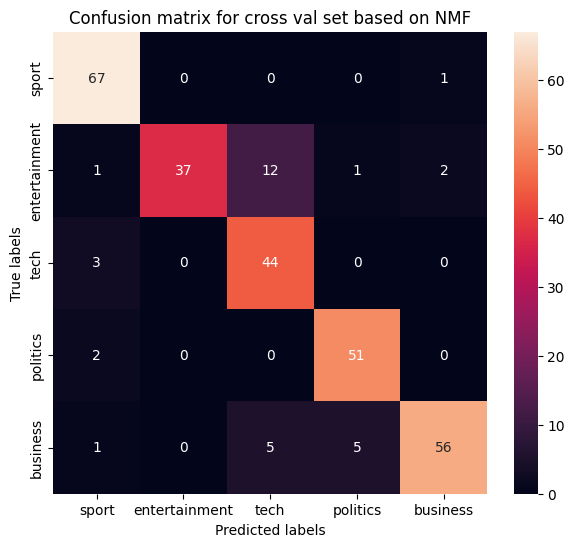

In [212]:
# Evaluate model with cross validation data
y_pred_cv = nmf_model.predict(crossval_data)
y_true_cv = crossval_data.df['Category']
acc = metrics.accuracy_score(y_true_cv,y_pred_cv)
print('\nAccuracy for cross val set based on NMF: {:.3f}%'.format(acc*100))
MyData.plot_confusion_matrix(y_true_cv,y_pred_cv,'Confusion matrix for cross val set based on NMF')

In [213]:
# Predict categories
y_pred_test = nmf_model.predict(test_data)
t_df = test_data.df.copy()
t_df['predicted Category']=y_pred_test
print('Predicted categories on testing set:')
t_df

Predicted categories on testing set:


,ArticleId,Text,predicted Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,business
731,373,u number to play at grammy awards show irish r...,entertainment
732,1704,sport betting rules in spotlight a group of mp...,tech
733,206,alfa romeos to get gm engines fiat is to sto...,business


In [215]:
# DataFrame for submission
nmf_predictions = test_data.df.copy()
nmf_predictions['Category']=y_pred_test
nmf_predictions.drop("Text",axis=1,inplace=True)
nmf_predictions

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,tech
733,206,business


In [218]:
nmf_predictions.columns

Index(['ArticleId', 'Category'], dtype='object')

In [220]:
nmf_predictions.to_csv("BBC Predictions.csv",index=False)